# Modelling arrivals and departures of EVs as a Poisson distribution 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import json
import datetime
from IPython.display import clear_output

pd.set_option('display.max_rows', 500)

In [2]:
# Parameters
columns = ['_id', 'clusterID', 'connectionTime', 'disconnectTime',
           'doneChargingTime', 'kWhDelivered', 'sessionID', 'siteID',
           'spaceID', 'stationID', 'timezone', 'userID'] #, 'userInputs']

In [3]:
with open("data/acndata_sessions.json", "r") as read_file:
    data1 = json.loads(read_file.read())
with open("data/acndata_sessions_2.json", "r") as read_file:
    data2 = json.loads(read_file.read())

In [4]:
i = 0
data1["_items"][i]["_id"]
print(data1["_items"][0]["connectionTime"])
print(data1["_items"][17530]["connectionTime"])

Wed, 25 Apr 2018 11:08:04 GMT
Tue, 12 Mar 2019 15:22:54 GMT


In [5]:
print(len(data1["_items"]))
print(len(data2["_items"]))

17531
15087


In [6]:
def load_acnJSON(columns, file_path):
    with open(file_path, "r") as read_file:
        data = json.loads(read_file.read())
    dict_data = dict.fromkeys(columns)
    for key in dict_data.keys():
        dict_data[key] = []
        
    for session in data["_items"]:
        for col in columns:
            dict_data[col].append(session[col])
        
    df = pd.DataFrame.from_dict(dict_data)
    return df
        
# Loading data in two overlapping files due to ACN's server's constraints
df1 = load_acnJSON(columns, "data/acndata_sessions.json")  
df2 = load_acnJSON(columns, "data/acndata_sessions_2.json")

In [7]:
# In WebClient id2 should be 15,087
# In WebClient ids should be 31,424

id1 = df1["_id"].unique()
id2 = df2["_id"].unique()
ids = np.concatenate((id1, id2))
print("id1: (unique, count)", len(np.unique(id1)), len(id1))
print("id2: (unique, count)", len(np.unique(id2)), len(id2))
print("ids: (unique, count)", len(np.unique(ids)), len(ids))

id1: (unique, count) 17531 17531
id2: (unique, count) 15087 15087
ids: (unique, count) 31424 32618


In [8]:
# Processing dataset
df_acn_all = pd.concat([df1, df2])
df_acn_all = df_acn_all.drop_duplicates()
print("Only one timezone:", df_acn_all["timezone"].unique())
timezone = df_acn_all["timezone"].unique()[0]

df_acn_all["connectionDT"]   = pd.to_datetime(df_acn_all["connectionTime"], utc=True).dt.tz_convert(timezone)
df_acn_all["disconnectDT"]   = pd.to_datetime(df_acn_all["disconnectTime"], utc=True).dt.tz_convert(timezone)
df_acn_all["doneChargingDT"] = pd.to_datetime(df_acn_all["doneChargingTime"], utc=True).dt.tz_convert(timezone)

df_acn_all["connectionDate"]   = df_acn_all["connectionDT"].apply(lambda x: x.date()) 
df_acn_all["disconnectDate"]   = df_acn_all["disconnectDT"].apply(lambda x: x.date()) 
df_acn_all["doneChargingDate"] = df_acn_all["doneChargingDT"].apply(lambda x: x.date()) 

df_acn_all["connectionSec"]   = df_acn_all["connectionDT"].apply(lambda x: datetime.timedelta(hours=x.hour,minutes=x.minute,seconds=x.second).total_seconds()) 
df_acn_all["disconnectSec"]   = df_acn_all["disconnectDT"].apply(lambda x: datetime.timedelta(hours=x.hour,minutes=x.minute,seconds=x.second).total_seconds()) 
df_acn_all["doneChargingSec"] = df_acn_all["doneChargingDT"].apply(lambda x: datetime.timedelta(hours=x.hour,minutes=x.minute,seconds=x.second).total_seconds()\
                                                                  if not x is pd.NaT else np.nan ) 
df_acn_all.info()

Only one timezone: ['America/Los_Angeles']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 31424 entries, 0 to 15086
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype                              
---  ------            --------------  -----                              
 0   _id               31424 non-null  object                             
 1   clusterID         31424 non-null  object                             
 2   connectionTime    31424 non-null  object                             
 3   disconnectTime    31424 non-null  object                             
 4   doneChargingTime  29369 non-null  object                             
 5   kWhDelivered      31424 non-null  float64                            
 6   sessionID         31424 non-null  object                             
 7   siteID            31424 non-null  object                             
 8   spaceID           31424 non-null  object                             
 9   stationID         

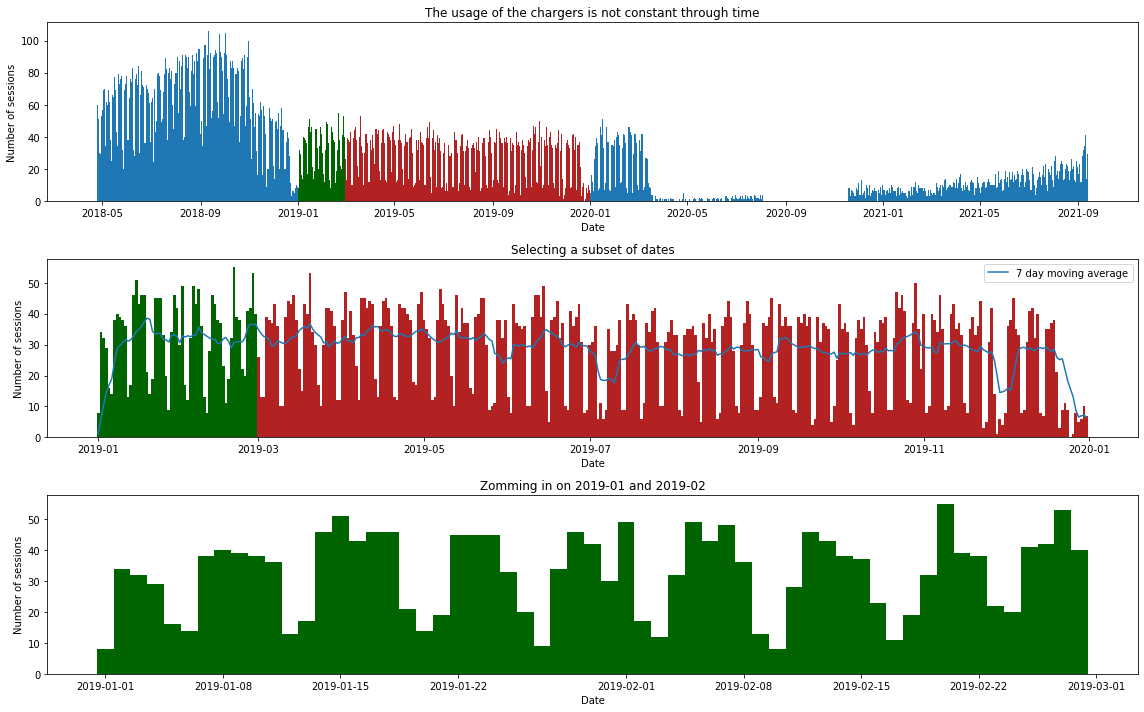

In [9]:
x,y = np.unique(df_acn_all["connectionDate"], return_counts=True)

start_date = datetime.datetime.strptime("2019-01-01", "%Y-%m-%d").date()
end_date = datetime.datetime.strptime("2020-01-01", "%Y-%m-%d").date()

df_acn = df_acn_all[(start_date <= df_acn_all["connectionDate"]) & (df_acn_all["connectionDate"] < end_date)].reset_index(drop = True).copy()
xs,ys = np.unique(df_acn["connectionDate"], return_counts=True)

start_date2 = datetime.datetime.strptime("2019-01-01", "%Y-%m-%d").date()
end_date2 = datetime.datetime.strptime("2019-03-01", "%Y-%m-%d").date()
df_acn_sub = df_acn_all[(start_date2 <= df_acn_all["connectionDate"]) & (df_acn_all["connectionDate"] < end_date2)]
xs2, ys2 = np.unique(df_acn_sub["connectionDate"], return_counts=True)

fig1 = plt.figure(figsize=(16, 10))
ax1 = fig1.add_subplot(3,1,1)
ax1.bar(x,y, width=1)
ax1.bar(xs,ys, color = "firebrick", width=1)
ax1.bar(xs2,ys2, color = "darkgreen", width=1)
ax1.set_xlabel("Date")
ax1.set_ylabel("Number of sessions")
ax1.set_title("The usage of the chargers is not constant through time")

ax2 = fig1.add_subplot(3,1,2)
mavg_d = 7
mavg = np.zeros((mavg_d))
mavg_ys = np.zeros(ys.shape) 
for i, n in enumerate(ys):
    mavg = np.roll(mavg, -1)
    mavg[-1] = n
    mavg_ys[i] = np.mean(mavg)
    

ax2.bar(xs,ys, color = 'firebrick', width=1)
ax2.plot(xs,mavg_ys, label = f"{mavg_d} day moving average")
ax2.bar(xs2,ys2, color = "darkgreen", width=1)
ax2.set_xlabel("Date")
ax2.set_ylabel("Number of sessions")
ax2.set_title("Selecting a subset of dates")
ax2.legend()


ax3 = fig1.add_subplot(3,1,3)
ax3.bar(xs2,ys2, color = 'darkgreen', width = 1)
ax3.set_xlabel("Date")
ax3.set_ylabel("Number of sessions")
ax3.set_title("Zomming in on 2019-01 and 2019-02")

fig1.tight_layout()


In [10]:
df_acn.describe()

,kWhDelivered,connectionSec,disconnectSec,doneChargingSec
count,10616.000000,10616.000000,10616.000000,10150.000000
mean,8.922078,42165.075735,59113.024586,50268.966700
std,9.155190,13417.459663,13344.489609,13888.555135
min,0.502000,34.000000,39.000000,28.000000
25%,2.635000,32474.000000,53438.250000,40270.000000
50%,6.233000,36958.500000,62152.500000,48755.000000
75%,11.898500,48874.750000,66971.250000,59953.250000
max,75.528000,86273.000000,86337.000000,86333.000000


In [11]:
df_acn.head()

,_id,clusterID,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,...,userID,connectionDT,disconnectDT,doneChargingDT,connectionDate,disconnectDate,doneChargingDate,connectionSec,disconnectSec,doneChargingSec
0,5c412c1df9af8b12cb56c27c,0039,"Tue, 01 Jan 2019 17:41:45 GMT","Tue, 01 Jan 2019 18:39:21 GMT","Tue, 01 Jan 2019 18:40:21 GMT",0.900,2_39_138_566_2019-01-01 17:41:44.784919,0002,CA-512,2-39-138-566,...,None,2019-01-01 09:41:45-08:00,2019-01-01 10:39:21-08:00,2019-01-01 10:40:21-08:00,2019-01-01,2019-01-01,2019-01-01,34905.0,38361.0,38421.0
1,5c412c1df9af8b12cb56c27d,0039,"Tue, 01 Jan 2019 18:09:17 GMT","Wed, 02 Jan 2019 02:39:32 GMT","Tue, 01 Jan 2019 20:16:10 GMT",12.534,2_39_79_379_2019-01-01 18:09:16.991864,0002,CA-327,2-39-79-379,...,000000558,2019-01-01 10:09:17-08:00,2019-01-01 18:39:32-08:00,2019-01-01 12:16:10-08:00,2019-01-01,2019-01-01,2019-01-01,36557.0,67172.0,44170.0
2,5c412c1df9af8b12cb56c27e,0039,"Tue, 01 Jan 2019 18:39:25 GMT","Tue, 01 Jan 2019 19:18:49 GMT","Tue, 01 Jan 2019 19:19:47 GMT",0.883,2_39_138_566_2019-01-01 18:39:24.566872,0002,CA-512,2-39-138-566,...,None,2019-01-01 10:39:25-08:00,2019-01-01 11:18:49-08:00,2019-01-01 11:19:47-08:00,2019-01-01,2019-01-01,2019-01-01,38365.0,40729.0,40787.0
3,5c412c1df9af8b12cb56c27f,0039,"Tue, 01 Jan 2019 19:18:53 GMT","Tue, 01 Jan 2019 20:14:07 GMT","Tue, 01 Jan 2019 19:59:08 GMT",0.879,2_39_138_566_2019-01-01 19:18:52.843645,0002,CA-512,2-39-138-566,...,None,2019-01-01 11:18:53-08:00,2019-01-01 12:14:07-08:00,2019-01-01 11:59:08-08:00,2019-01-01,2019-01-01,2019-01-01,40733.0,44047.0,43148.0
4,5c412c1df9af8b12cb56c280,0039,"Tue, 01 Jan 2019 21:05:57 GMT","Wed, 02 Jan 2019 02:03:02 GMT","Wed, 02 Jan 2019 01:59:27 GMT",16.136,2_39_79_378_2019-01-01 21:05:56.972890,0002,CA-326,2-39-79-378,...,000001135,2019-01-01 13:05:57-08:00,2019-01-01 18:03:02-08:00,2019-01-01 17:59:27-08:00,2019-01-01,2019-01-01,2019-01-01,47157.0,64982.0,64767.0


In [12]:
g_interval = 60*60 # group in 1 hour intervals (measured in seconds)
df_acn["arrtime_gid"] = df_acn["connectionSec"] // g_interval
df_acn["deptime_gid"] = df_acn["disconnectSec"] // g_interval


gdf_arrcounts = df_acn.groupby("arrtime_gid").agg({'_id': 'count'}).reset_index().rename(columns = {'_id': 'arr_count', 'arrtime_gid': 'gid'})
gdf_depcounts = df_acn.groupby("deptime_gid").agg({'_id': 'count'}).reset_index().rename(columns = {'_id': 'dep_count', 'deptime_gid': 'gid'})

gdf_counts = gdf_arrcounts.join(gdf_depcounts.set_index('gid'), on = 'gid')

# Verifying join... the ~~~fancy~~~ way
for row_arr, row_dep, row_tot in zip(gdf_arrcounts.iterrows(), gdf_depcounts.iterrows(), gdf_counts.iterrows()):
    print(f"{row_arr[1].gid}, {row_arr[1].arr_count} \t+ {row_dep[1].gid}, {row_dep[1].dep_count} \t-> {row_tot[1].gid}, {row_tot[1].arr_count}, {row_tot[1].dep_count}")

num_sessions = df_acn.shape[0]
num_days = df_acn["connectionDate"].nunique() # Only date missing is 2019-12-25
gdf_counts["arr_avg"] = gdf_counts["arr_count"] / num_days
gdf_counts["dep_avg"] = gdf_counts["dep_count"] / num_days
print("\nTotals:")
print()
print("Num sessions:", num_sessions)
print("Num days:", num_days)
print(f"Avg. sessions per day {num_sessions/num_days:.2f}")

gdf_counts.sum()


0.0, 18.0 	+ 0.0, 58.0 	-> 0.0, 18.0, 58.0
1.0, 5.0 	+ 1.0, 35.0 	-> 1.0, 5.0, 35.0
2.0, 7.0 	+ 2.0, 21.0 	-> 2.0, 7.0, 21.0
3.0, 1.0 	+ 3.0, 13.0 	-> 3.0, 1.0, 13.0
4.0, 4.0 	+ 4.0, 11.0 	-> 4.0, 4.0, 11.0
5.0, 24.0 	+ 5.0, 8.0 	-> 5.0, 24.0, 8.0
6.0, 182.0 	+ 6.0, 91.0 	-> 6.0, 182.0, 91.0
7.0, 400.0 	+ 7.0, 127.0 	-> 7.0, 400.0, 127.0
8.0, 1950.0 	+ 8.0, 93.0 	-> 8.0, 1950.0, 93.0
9.0, 2140.0 	+ 9.0, 172.0 	-> 9.0, 2140.0, 172.0
10.0, 1390.0 	+ 10.0, 238.0 	-> 10.0, 1390.0, 238.0
11.0, 644.0 	+ 11.0, 424.0 	-> 11.0, 644.0, 424.0
12.0, 750.0 	+ 12.0, 556.0 	-> 12.0, 750.0, 556.0
13.0, 701.0 	+ 13.0, 410.0 	-> 13.0, 701.0, 410.0
14.0, 407.0 	+ 14.0, 501.0 	-> 14.0, 407.0, 501.0
15.0, 281.0 	+ 15.0, 654.0 	-> 15.0, 281.0, 654.0
16.0, 338.0 	+ 16.0, 1331.0 	-> 16.0, 338.0, 1331.0
17.0, 335.0 	+ 17.0, 2173.0 	-> 17.0, 335.0, 2173.0
18.0, 412.0 	+ 18.0, 1545.0 	-> 18.0, 412.0, 1545.0
19.0, 238.0 	+ 19.0, 952.0 	-> 19.0, 238.0, 952.0
20.0, 179.0 	+ 20.0, 520.0 	-> 20.0, 179.0, 520.0
21.0, 

gid            276.000000
arr_count    10616.000000
dep_count    10616.000000
arr_avg         29.164835
dep_avg         29.164835
dtype: float64

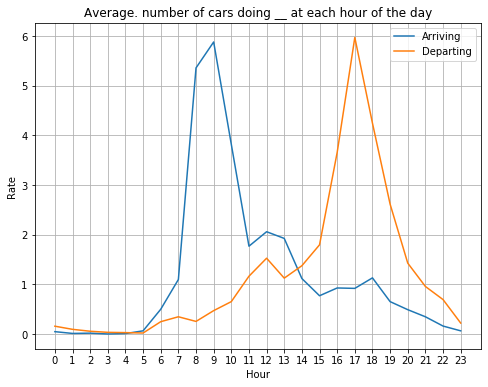

In [15]:
fig1 = plt.figure(figsize = (8,6))
ax1 = fig1.add_subplot(1,1,1)

ax1.plot(gdf_counts["gid"].to_numpy(), gdf_counts["arr_avg"].to_numpy(), label="Arriving")
ax1.plot(gdf_counts["gid"].to_numpy(), gdf_counts["dep_avg"].to_numpy(), label="Departing")

ax1.set_xticks(np.arange(0,24,1))
ax1.grid()
ax1.set_xlabel("Hour")
ax1.set_ylabel("Rate")
ax1.set_title("Average. number of cars doing __ at each hour of the day")
ax1.legend()


In [14]:
gdf_counts.to_csv("outputs/gdf_counts.csv", index=False)